In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
!pip install backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173913 sha256=68ecd9f98821beb530195548d0215e5060dac677c70480abf93e9a4418d270b5
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [25]:
df = pd.read_csv('btc_1h_processed.csv')
df.head()

,open,high,low,close,volume,ma7,ma21,rsi,%d,w%r,upper,lower,vwap,ema_f,ema_s,macd,macd_signal,return,target_cls
0,13715.65,13715.65,13400.01,13529.01,443.356199,13529.010000,13529.010000,NaN,40.869345,-59.130655,NaN,NaN,13529.010000,13529.010000,13529.010000,0.000000,0.000000,-0.024093,0
1,13528.99,13595.89,13155.38,13203.06,383.697006,13366.035000,13366.035000,0.000000,24.689764,-91.489817,NaN,NaN,13377.791144,13354.393929,13359.766731,-5.372802,-2.984890,0.009628,1
2,13203.00,13418.43,13200.00,13330.18,429.064572,13354.083333,13354.083333,28.057475,26.859590,-68.800757,NaN,NaN,13361.528135,13345.144126,13349.136506,-3.992380,-3.397796,0.005990,1
3,13330.26,13611.27,13290.00,13410.03,420.087030,13368.070000,13368.070000,38.836974,28.386909,-54.548700,NaN,NaN,13373.683573,13364.994545,13366.159666,-1.165121,-2.641470,0.014242,1
4,13434.98,13623.29,13322.15,13601.01,340.807329,13414.658000,13414.658000,54.973063,52.062993,-20.461563,NaN,NaN,13412.094107,13426.570616,13420.622427,5.948189,-0.086240,-0.003089,0


In [4]:
df.dropna(inplace=True)

In [5]:
high_low = df['high'] - df['low']
high_close = abs(df['high'] - df['close'].shift())
low_close = abs(df['low'] - df['close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR'] = true_range.rolling(14,min_periods=1).mean()

In [79]:

df.dropna(inplace=True)
df.head()

,level_0,index,ma7,ma21,rsi,%d,w%r,upper,lower,vwap,...,ema_s,macd,macd_signal,return,target_cls,Open,High,Low,Close,Volume
19,19,19,13127.251429,13347.688500,41.616146,35.792117,-54.108839,13807.723315,12887.653685,13325.517235,...,13284.368785,-48.521945,-36.248759,0.011999,1,13135.00,13290.65,13106.61,13240.37,252.004885
20,20,20,13181.857143,13350.143333,39.628874,47.560089,-39.241028,13794.071587,12888.328413,13329.495998,...,13294.987166,-36.219222,-36.242797,0.006103,1,13222.03,13472.00,13222.03,13399.24,412.026868
21,21,21,13220.374286,13347.857619,47.386741,60.282089,-25.803865,13807.178436,12903.016564,13335.717700,...,13311.872540,-22.143194,-33.401914,-0.002152,0,13399.23,13580.67,13380.82,13481.01,326.923135
22,22,22,13249.660000,13359.711905,48.561459,70.419818,-23.695652,13815.134654,12907.242346,13339.985078,...,13324.383089,-12.181586,-29.132647,-0.005352,0,13494.99,13599.70,13450.96,13452.00,303.301385
23,23,23,13301.374286,13362.084286,42.699059,73.296619,-30.610626,13813.151342,12906.222658,13341.589494,...,13329.274183,-7.731688,-24.832147,0.027654,1,13455.24,13500.00,13355.01,13380.00,345.218495


In [90]:
def ATR(data, period=14):
    high = data['High']
    low = data['Low']
    close = data['Close']
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = true_range.ewm(span=period, adjust=False).mean()
    return atr

In [91]:
df['atr']=ATR(df)

In [92]:
split=0.8
split_row = int(split*len(df))
train_df = df[:split_row]
test_df = df[split_row:]

In [93]:
train_df.head()

,level_0,index,ma7,ma21,rsi,%d,w%r,upper,lower,vwap,...,macd,macd_signal,return,target_cls,Open,High,Low,Close,Volume,atr
19,19,19,13127.251429,13347.688500,41.616146,35.792117,-54.108839,13807.723315,12887.653685,13325.517235,...,-48.521945,-36.248759,0.011999,1,13135.00,13290.65,13106.61,13240.37,252.004885,184.040000
20,20,20,13181.857143,13350.143333,39.628874,47.560089,-39.241028,13794.071587,12888.328413,13329.495998,...,-36.219222,-36.242797,0.006103,1,13222.03,13472.00,13222.03,13399.24,412.026868,192.830667
21,21,21,13220.374286,13347.857619,47.386741,60.282089,-25.803865,13807.178436,12903.016564,13335.717700,...,-22.143194,-33.401914,-0.002152,0,13399.23,13580.67,13380.82,13481.01,326.923135,193.766578
22,22,22,13249.660000,13359.711905,48.561459,70.419818,-23.695652,13815.134654,12907.242346,13339.985078,...,-12.181586,-29.132647,-0.005352,0,13494.99,13599.70,13450.96,13452.00,303.301385,187.763034
23,23,23,13301.374286,13362.084286,42.699059,73.296619,-30.610626,13813.151342,12906.222658,13341.589494,...,-7.731688,-24.832147,0.027654,1,13455.24,13500.00,13355.01,13380.00,345.218495,182.059963


In [94]:
x_train=train_df.drop(columns=['target_cls','return'],axis=1)
y_train=train_df['target_cls']
x_test=test_df.drop(columns=['target_cls','return'],axis=1)
y_test=test_df['target_cls']

In [95]:
clf=RandomForestClassifier(max_depth=5,min_samples_leaf=2,min_samples_split=10,random_state=42)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

In [96]:
accuracy

0.5314910927198766

In [87]:
x_train.head()


,level_0,index,ma7,ma21,rsi,%d,w%r,upper,lower,vwap,ema_f,ema_s,macd,macd_signal,Open,High,Low,Close,Volume
19,19,19,13127.251429,13347.688500,41.616146,35.792117,-54.108839,13807.723315,12887.653685,13325.517235,13235.846840,13284.368785,-48.521945,-36.248759,13135.00,13290.65,13106.61,13240.37,252.004885
20,20,20,13181.857143,13350.143333,39.628874,47.560089,-39.241028,13794.071587,12888.328413,13329.495998,13258.767944,13294.987166,-36.219222,-36.242797,13222.03,13472.00,13222.03,13399.24,412.026868
21,21,21,13220.374286,13347.857619,47.386741,60.282089,-25.803865,13807.178436,12903.016564,13335.717700,13289.729346,13311.872540,-22.143194,-33.401914,13399.23,13580.67,13380.82,13481.01,326.923135
22,22,22,13249.660000,13359.711905,48.561459,70.419818,-23.695652,13815.134654,12907.242346,13339.985078,13312.201503,13324.383089,-12.181586,-29.132647,13494.99,13599.70,13450.96,13452.00,303.301385
23,23,23,13301.374286,13362.084286,42.699059,73.296619,-30.610626,13813.151342,12906.222658,13341.589494,13321.542495,13329.274183,-7.731688,-24.832147,13455.24,13500.00,13355.01,13380.00,345.218495


In [60]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(precision, recall)

0.5422885572139303 0.45836837678721615


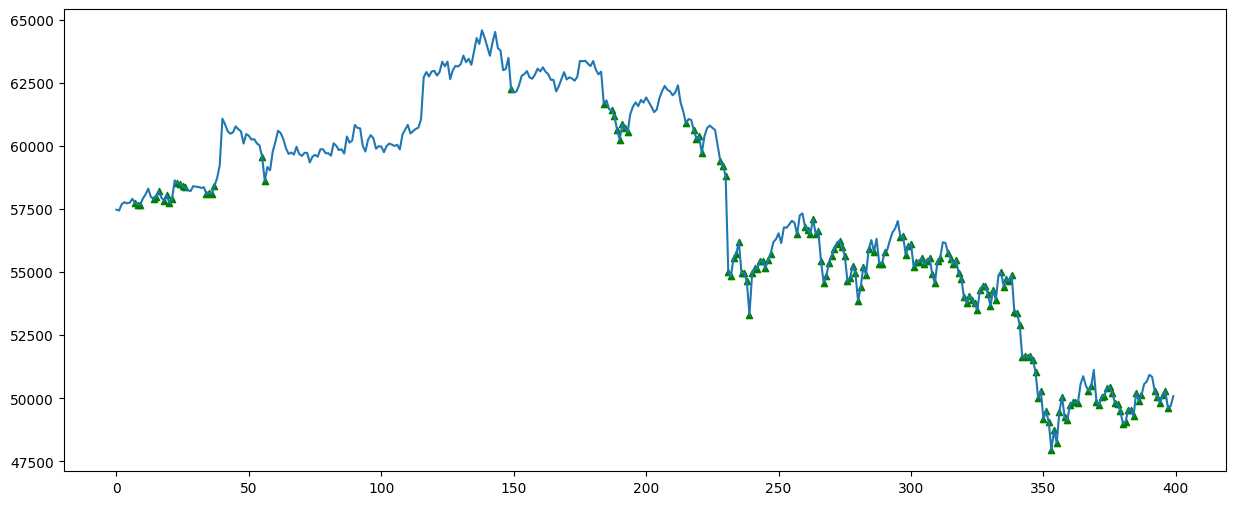

In [101]:
X_test=x_test[:400]
plt.figure(figsize=(15, 6))
close_prices = X_test['Close'].values
x_axis = np.arange(len(close_prices))
buy=(y_pred[:400]==1)
sell=(y_pred[:400]==0)
plt.plot(x_axis,close_prices)
plt.scatter(x_axis[buy],close_prices[buy], color='green', label='Buy Signal',marker='^', s=20)
#plt.scatter(x_axis[sell],close_prices[sell], color='red', label='Sell Signal',marker='v', s=20)

In [97]:
def predict(model,X):
  return pd.Series(model.predict(X))
def price(df):
    return df.Close

In [99]:
class Strat(Strategy):
    model=clf
    X=x_test
    sl=1
    tp=2
    def init(self):
        self.y=self.I(predict,self.model,self.X)
        self.pr=self.I(price,self.X)
        self.ATR=self.I(ATR,self.X)
    def next(self):
        prev_wr=x_test['w%r'].iloc[-2]
        cur_wr = x_test['w%r'].iloc[-1]
        macd_line = x_test['macd'].iloc[-1]
        signal_line =x_test['macd_signal'].iloc[-1]
        p=self.pr[-1]
        atr=self.ATR[-1]
        slt= int(self.sl)
        tpt= int(self.tp)
        if prev_wr>-50 and cur_wr<-50 and macd_line>signal_line and (self.y==1):
            self.buy(sl=p-slt*atr, tp=p+tpt*atr)

        elif prev_wr<-50 and cur_wr>-50 and macd_line<signal_line and (self.y==0):
            self.sell()

bt=Backtest(x_test, Strat, cash=100_000, commission=0.0005)
stats=bt.run()
stats

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1054: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  (data.index.is_numeric() and
<ipython-input-99-82ddbc4517f6>:25: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt=Backtest(x_test, Strat, cash=100_000, commission=0.0005)


,0
Start,28534.0
End,35662.0
Duration,7128.0
Exposure Time [%],63.907981
Equity Final [$],0.0
Equity Peak [$],165704.36415
Return [%],-100.0
Buy & Hold Return [%],-34.086685
Return (Ann.) [%],0.0
Volatility (Ann.) [%],NaN
